In [331]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

# load the provided data
train_features = pd.read_csv('VarianceHandledDataset.csv',index_col=[0])

nn=train_features.isnull().sum()/len(train_features)

In [332]:
train_features.head()

,Gender,NumberOfFixations,FixationDuration(ms),FixationDurationAvg(ms),FixationDurationStd(ms),NumberOfSaccades,SaccadeDuration(ms),SaccadeDurationAvg(ms),SaccadesDurationStd(ms),GazePointX(ADCSpx),GazePointY(ADCSpx),PupilDiameterLeft(mm),PupilDiameterRight(mm),Class
ParticipantID,,,,,,,,,,,,,,
003ADHDETWM,female,-0.184230,-0.197407,0.034763,-0.281520,-0.714749,-0.373633,-0.798927,-0.445699,-1.118040,-0.490957,-0.873751,-0.259639,Non-ADHD
003ADHDETWM,female,0.044121,-0.131856,0.360355,0.352504,-0.714749,-0.373633,-0.798927,-0.445699,-0.729539,-0.060831,-1.460183,0.096370,Non-ADHD
003ADHDETWM,female,-0.155686,-0.188350,0.153160,-0.281520,-0.714749,-0.373633,-0.798927,-0.445699,0.053548,0.558789,-1.084811,0.393743,Non-ADHD
003ADHDETWM,female,-0.155686,-0.188350,0.153160,-0.281520,-0.714749,-0.373633,-0.798927,-0.445699,0.059165,-0.085282,-1.131467,-0.347129,Non-ADHD
003ADHDETWM,female,0.443734,0.134907,1.150429,0.045810,-0.714749,-0.373633,-0.798927,-0.445699,-0.977438,0.317056,-0.540392,0.291647,Non-ADHD


In [333]:
nn

Gender                     0.0
NumberOfFixations          0.0
FixationDuration(ms)       0.0
FixationDurationAvg(ms)    0.0
FixationDurationStd(ms)    0.0
NumberOfSaccades           0.0
SaccadeDuration(ms)        0.0
SaccadeDurationAvg(ms)     0.0
SaccadesDurationStd(ms)    0.0
GazePointX(ADCSpx)         0.0
GazePointY(ADCSpx)         0.0
PupilDiameterLeft(mm)      0.0
PupilDiameterRight(mm)     0.0
Class                      0.0
dtype: float64

No missing values found

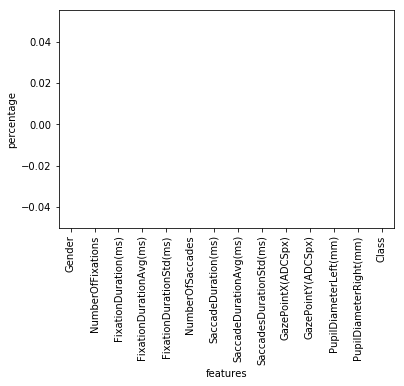

In [334]:
p=nn.plot.bar()
p.set_xlabel('features')
p.set_ylabel('percentage')

In [335]:
train_features['Class']=pd.get_dummies(train_features['Class'],prefix='Class')
train_features['Gender']=pd.get_dummies(train_features['Gender'],prefix='Gender')

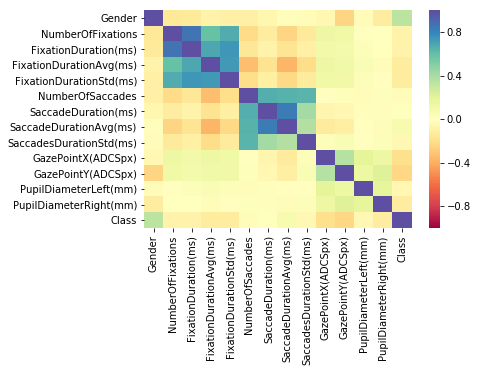

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.figure(figsize=(2,2))
sns.heatmap(train_features.corr(),
            vmin=-1,
            cmap='Spectral',
           xticklabels=True,
           yticklabels=True);

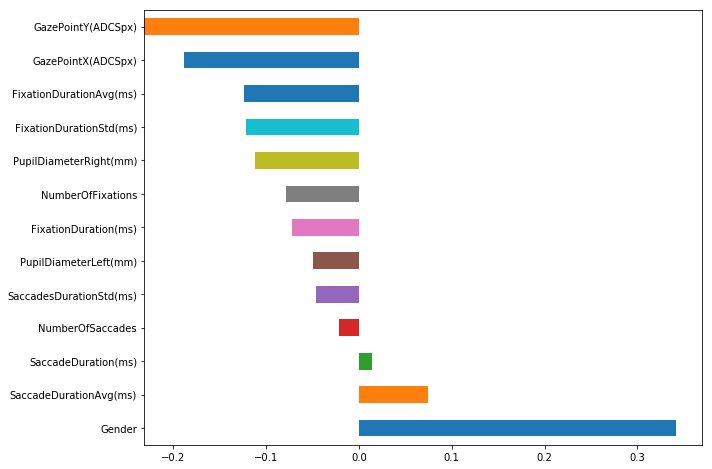

In [337]:
train_features.corr().Class.drop('Class').sort_values(ascending=False).plot.barh(figsize=(10,8))

train_features['GazePointY_rm']=train_features['GazePointY(ADCSpx)'].rolling(10).mean()
train_features['GazePointY_rm'].fillna(0)

train_features['GazePointX(ADCSpx)_binned']=pd.cut(train_features['GazePointX(ADCSpx)'],100)
train_features['GazePointY(ADCSpx)_binned']=pd.cut(train_features['GazePointY(ADCSpx)'],100)

s=train_features['GazePointY(ADCSpx)_binned']
train_features['GazePointY(ADCSpx)_binned'] =[(a.left + a.right)/2 for a in s]
s=train_features['GazePointX(ADCSpx)_binned']
train_features['GazePointX(ADCSpx)_binned'] =[(a.left + a.right)/2 for a in s]

train_features['GazePointY(ADCSpx)_binned']

In [338]:
from sklearn.utils import shuffle

train_features=shuffle(train_features)
train_features_subtrain = train_features.head(800)
train_features_subtest = train_features.tail(train_features.shape[0] - 800)

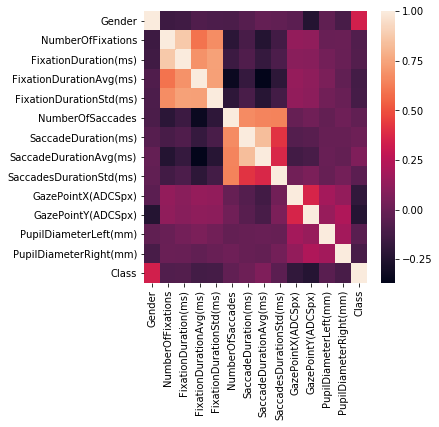

In [339]:
plt.figure(figsize=(5,5))
sns.heatmap(train_features.corr());

In [340]:
train_features_subtrain.Class.unique()

array([1, 0], dtype=uint64)

In [341]:
list(train_features)

['Gender',
 'NumberOfFixations',
 'FixationDuration(ms)',
 'FixationDurationAvg(ms)',
 'FixationDurationStd(ms)',
 'NumberOfSaccades',
 'SaccadeDuration(ms)',
 'SaccadeDurationAvg(ms)',
 'SaccadesDurationStd(ms)',
 'GazePointX(ADCSpx)',
 'GazePointY(ADCSpx)',
 'PupilDiameterLeft(mm)',
 'PupilDiameterRight(mm)',
 'Class']

In [348]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

def get_rf_best_model(X,y):
#     features=['Gender',
#              'NumberOfFixations',
#              'FixationDuration(ms)',
#              'FixationDurationAvg(ms)',
#              'FixationDurationStd(ms)',
#              'NumberOfSaccades',
#              'SaccadeDuration(ms)',
#              'SaccadeDurationAvg(ms)',
#              'SaccadesDurationStd(ms)',
#              'PupilDiameterLeft(mm)',
#              'PupilDiameterRight(mm)',
#              'GazePointX(ADCSpx)_binned',
#              'GazePointY(ADCSpx)_binned']
#     X=X[features]
    
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
#     rfr = RandomForestClassifier(n_jobs=2, random_state=0)
    rfr=rfr.fit(X,y)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10)
    print(scores)
    
    print("Accuracy: ",scores.mean())
    print("Accuracy std: ",scores.std())

    return rfr
    

In [349]:
y_train=train_features_subtrain['Class']
X_train=train_features_subtrain.drop('Class', axis=1)

In [350]:
y_test=train_features_subtest['Class']
X_test=train_features_subtest.drop('Class', axis=1)

In [351]:
X_test.isnull().sum()

Gender                     0
NumberOfFixations          0
FixationDuration(ms)       0
FixationDurationAvg(ms)    0
FixationDurationStd(ms)    0
NumberOfSaccades           0
SaccadeDuration(ms)        0
SaccadeDurationAvg(ms)     0
SaccadesDurationStd(ms)    0
GazePointX(ADCSpx)         0
GazePointY(ADCSpx)         0
PupilDiameterLeft(mm)      0
PupilDiameterRight(mm)     0
dtype: int64

In [352]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (y_test.shape[0],(y_test != y_pred).sum()))

Number of mislabeled points out of a total 11668 points : 3845


In [353]:
model2=get_rf_best_model(X_train,y_train)
#iq_model2=get_rf_best_model(iq_x,iq_y)

[0.7654321  0.7654321  0.79012346 0.82716049 0.7625     0.7625
 0.75949367 0.81012658 0.81012658 0.75949367]
Accuracy:  0.7812388654477262
Accuracy std:  0.02450395306722775


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000023EFDDDF98>]],
      dtype=object)

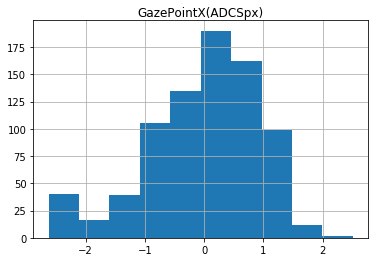

In [354]:
train_features_subtrain.hist(column='GazePointX(ADCSpx)')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000023F2636780>]],
      dtype=object)

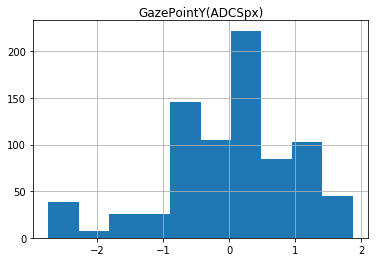

In [355]:
train_features_subtrain.hist(column='GazePointY(ADCSpx)')

In [356]:
predictions = model2.predict(X_test)

In [357]:
predictions

array([0, 1, 1, ..., 0, 1, 0], dtype=uint8)

In [358]:
pd.crosstab(y_test, predictions, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,3492,1638
1,1000,5538


In [359]:
list(zip(X_train, model2.feature_importances_))

[('Gender', 0.14332702285932197),
 ('NumberOfFixations', 0.03066861314911196),
 ('FixationDuration(ms)', 0.035339636625707924),
 ('FixationDurationAvg(ms)', 0.02944566265446152),
 ('FixationDurationStd(ms)', 0.02037585450180125),
 ('NumberOfSaccades', 0.023276573726306853),
 ('SaccadeDuration(ms)', 0.030843332863981346),
 ('SaccadeDurationAvg(ms)', 0.02880857354743819),
 ('SaccadesDurationStd(ms)', 0.01969615550289332),
 ('GazePointX(ADCSpx)', 0.16081355335342867),
 ('GazePointY(ADCSpx)', 0.2519561267258446),
 ('PupilDiameterLeft(mm)', 0.085396662495979),
 ('PupilDiameterRight(mm)', 0.14005223199372327)]

In [360]:
from sklearn.ensemble import AdaBoostClassifier
model3 = AdaBoostClassifier()
model3.fit(X_train, y_train)
model3.score(X_test,y_test)

0.7398868700719917

In [361]:
predictions = model3.predict(X_test)

In [362]:
pd.crosstab(y_test, predictions, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,3636,1494
1,1541,4997


In [363]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.8099999999999999


In [401]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
model1 = AdaBoostClassifier(learning_rate=0.8001,random_state=20)
estimators.append(('adaboost', model1))
model2 = DecisionTreeClassifier(max_depth=7,random_state=9)
estimators.append(('cart', model2))
model3 = SVC(probability=True)
estimators.append(('svm', model3))
model4 = RandomForestClassifier(n_estimators =25,random_state=1,max_depth=50)
estimators.append(('randomforest', model4))
model5= GradientBoostingClassifier(learning_rate=0.1,random_state=6)
estimators.append(('gradientboost', model5))
model6 = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
estimators.append(('bagging', model6))

# create the ensemble model
ensemble = VotingClassifier(estimators,voting='soft')
results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=kfold)
print(results.mean())

0.8175000000000001


In [404]:
import pickle
from sklearn.externals import joblib

ensemble.fit(X_train,y_train)
joblib.dump(ensemble, 'eye_movement_ensembled.pkl') 

['eye_movement_ensembled.pkl']

In [409]:
predict_data=pd.read_csv('test_data_nadhd.csv',index_col=[0])
predict_data['Gender']=pd.get_dummies(predict_data['Gender'],prefix='Gender')

clf_from_joblib = joblib.load('eye_movement_ensembled.pkl') 
predictions=clf_from_joblib.predict(predict_data)
counts = np.bincount(predictions)
np.argmax(counts)

1

In [392]:
model= GaussianNB()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.6704662324305793

In [377]:
# Perform Grid-Search
gsc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'max_depth':range(1, 10),
        'random_state': range(1, 10),
        'n_estimators': range(1, 10),
    },
    cv=5, verbose=0,n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

KeyboardInterrupt: 

In [367]:
model= DecisionTreeClassifier(max_depth=7,random_state=9)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7620843332190607

In [368]:
best_params["max_depth"]

5

In [369]:
best_params["random_state"]

7